In [1]:
import pandas as pd
from transformers import RobertaTokenizer, RobertaModel
import torch
from torch import nn, optim
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split

tqdm.pandas()

### Load Dataset

In [2]:
df = pd.read_pickle('data/processed.pickle')
df.head()

,docstring,code,relevance,repo,func_url,split
0,Attempt to convert the specified value to epoc...,private static String coerceToEpoch(String s) ...,2,spring-projects/spring-boot,https://github.com/spring-projects/spring-boot...,train
1,Generate a server side cookie given the cookie...,private Cookie createCookie(String str) throws...,2,apache/spark,https://github.com/apache/spark/blob/25ee0474f...,train
2,Generate httponly cookie from HS2 cookie\n@par...,private static String getHttpOnlyCookieHeader(...,2,apache/spark,https://github.com/apache/spark/blob/25ee0474f...,train
3,Copies all files from source to target and set...,"public static void copy(Path sourcePath, Path ...",3,apache/flink,https://github.com/apache/flink/blob/b62db93bf...,train
4,Saves the configuration info to the disk.,public synchronized void save() {\n if ...,3,jenkinsci/jenkins,https://github.com/jenkinsci/jenkins/blob/44c4...,train


### Get Embeddings

In [3]:
EMBEDDING_DIMENSION = 400

def get_tokens_and_embeddings(natural_language, code, tokenizer, model):

    nl_tokens = tokenizer.tokenize(natural_language)
    code_tokens = tokenizer.tokenize(code)

    tokens = ['CLS'] + nl_tokens + ['SEP'] + code_tokens + ['EOS'] # Take from CodeBERT paper

    if len(tokens) > EMBEDDING_DIMENSION:
        tokens = tokens[:EMBEDDING_DIMENSION]

    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    embedding = model(torch.tensor(token_ids)[None, :])[0][0]

    pad_value_before = (EMBEDDING_DIMENSION - len(tokens)) // 2
    pad_value_after = pad_value_before + ((EMBEDDING_DIMENSION - len(tokens)) % 2)

    padded = nn.functional.pad(embedding, (0, 0, pad_value_before, pad_value_after), "constant", 0)

    return tokens, len(tokens), padded.detach().numpy()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
bert_model = RobertaModel.from_pretrained("microsoft/codebert-base")
bert_model.to(device)

print()

In [5]:
df[['tokens', 'token_count', 'embeddings']] = df.progress_apply(lambda x: get_tokens_and_embeddings(x['docstring'], x['code'], tokenizer=bert_tokenizer, model=bert_model), axis=1, result_type='expand')
df = df.drop(columns=['split'])
df.head()

100%|██████████| 315/315 [00:34<00:00,  9.26it/s]


,docstring,code,relevance,repo,func_url,tokens,token_count,embeddings
0,Attempt to convert the specified value to epoc...,private static String coerceToEpoch(String s) ...,2,spring-projects/spring-boot,https://github.com/spring-projects/spring-boot...,"[CLS, Attempt, Ġto, Ġconvert, Ġthe, Ġspecified...",202,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Generate a server side cookie given the cookie...,private Cookie createCookie(String str) throws...,2,apache/spark,https://github.com/apache/spark/blob/25ee0474f...,"[CLS, Gener, ate, Ġa, Ġserver, Ġside, Ġcookie,...",223,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,Generate httponly cookie from HS2 cookie\n@par...,private static String getHttpOnlyCookieHeader(...,2,apache/spark,https://github.com/apache/spark/blob/25ee0474f...,"[CLS, Gener, ate, Ġhttp, only, Ġcookie, Ġfrom,...",129,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,Copies all files from source to target and set...,"public static void copy(Path sourcePath, Path ...",3,apache/flink,https://github.com/apache/flink/blob/b62db93bf...,"[CLS, Cop, ies, Ġall, Ġfiles, Ġfrom, Ġsource, ...",253,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Saves the configuration info to the disk.,public synchronized void save() {\n if ...,3,jenkinsci/jenkins,https://github.com/jenkinsci/jenkins/blob/44c4...,"[CLS, S, aves, Ġthe, Ġconfiguration, Ġinfo, Ġt...",321,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### Explore data
All below adapted from: https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

<Axes: xlabel='relevance', ylabel='count'>

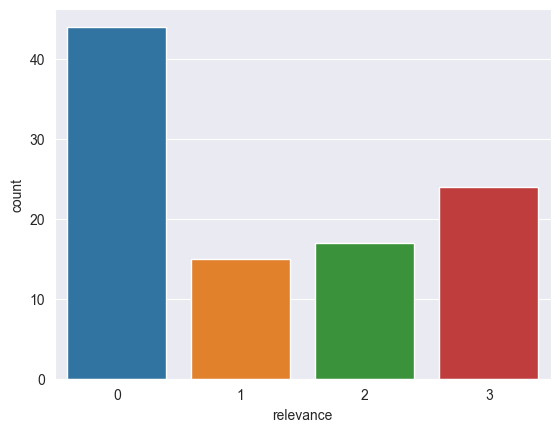

In [7]:
sns.countplot(df, x='relevance')

#### Create splits

In [8]:
X = df[['embeddings']]
y = df[['relevance']]

random_seed = 123

In [9]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=random_seed)

<Axes: xlabel='relevance', ylabel='count'>

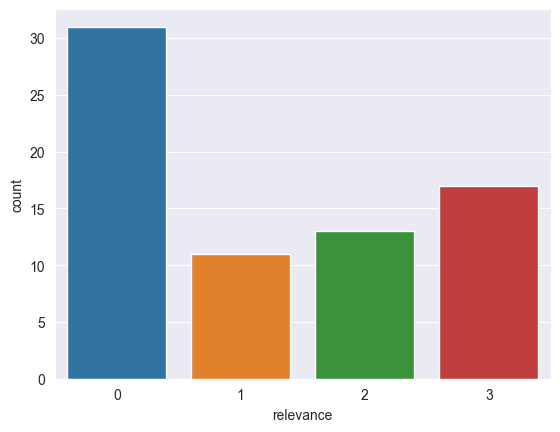

In [10]:
sns.countplot(y_train, x='relevance')

<Axes: xlabel='relevance', ylabel='count'>

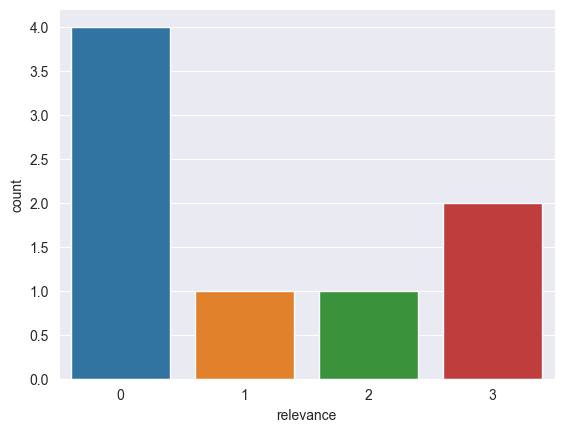

In [11]:
sns.countplot(y_val, x='relevance')

<Axes: xlabel='relevance', ylabel='count'>

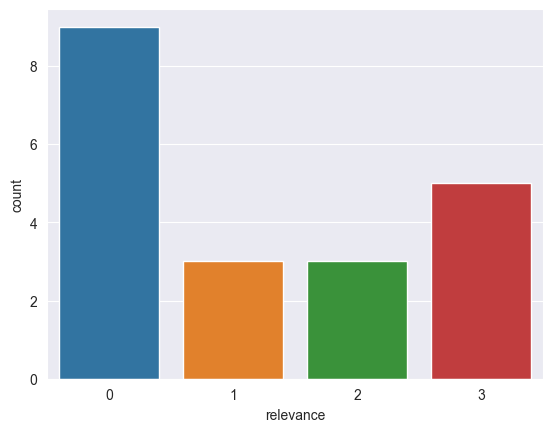

In [12]:
sns.countplot(y_test, x='relevance')

### Create dataloader

In [13]:
class RelevanceDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = torch.tensor(X_data.reset_index(drop=True).embeddings)
        self.y_data = torch.tensor(y_data.reset_index(drop=True).relevance).long()

    def __getitem__(self, item):
        return self.X_data[item], self.y_data[item]

    def __len__(self):
        return len(self.X_data)

In [14]:
train_dataset = RelevanceDataset(X_train, y_train)
val_dataset = RelevanceDataset(X_val, y_val)
test_dataset = RelevanceDataset(X_test, y_test)

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_30528/1746146353.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  self.X_data = torch.tensor(X_data.reset_index(drop=True).embeddings)


#### Oversample Dataset

In [15]:
target_list = []

for _, t in train_dataset:
    target_list.append(t)


target_list = torch.tensor(target_list)

class_count = [i for i in y_train.value_counts().values]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)

class_weights_all = class_weights[target_list]

weighted_sampler = WeightedRandomSampler(weights=class_weights_all, num_samples=len(class_weights_all), replacement=True)

### Model Parameters

In [16]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007

KERNEL_SIZE = 5
HIDDEN_LAYER_SIZE = 256

NUM_FEATURES = 400
NUM_CLASSES = 4

#### Setup Dataloaders

In [17]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

#### Define Model

In [33]:
class Classifier(nn.Module):
    def __init__(self, num_features, hidden_layer_size, kernel_size, num_class):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv1d(num_features, hidden_layer_size, kernel_size)
        self.conv2 = nn.Conv1d(hidden_layer_size, hidden_layer_size, kernel_size)
        self.fc1 = nn.Linear(7424, 7424)
        self.fc_out = nn.Linear(7424, num_class)

        self.pool = nn.MaxPool1d(kernel_size)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_out(x)

        return x

#### Train Model

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [34]:
model = Classifier(num_features=NUM_FEATURES, hidden_layer_size=HIDDEN_LAYER_SIZE, kernel_size=KERNEL_SIZE, num_class=NUM_CLASSES)

model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model

Classifier(
  (conv1): Conv1d(400, 256, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(256, 256, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=7424, out_features=7424, bias=True)
  (fc_out): Linear(in_features=7424, out_features=4, bias=True)
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [21]:
# TODO: What does this function measure?

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)

    correct_pred = (y_pred_tags == y_test)
    acc = correct_pred.sum() / len(correct_pred)

    return torch.round(acc * 100)


accuracy_stats = {
    'train': [],
    'val': []
}

loss_stats = {
    'train': [],
    'val': []
}

In [35]:
print("Begin training...")


for epoch in tqdm(range(1, EPOCHS + 1)):
    train_epoch_loss = 0
    train_epoch_acc = 0

    # TRAINING

    model.train()

    for X_train_batch, y_train_batch in train_loader:
        X_train_batch = X_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)

        train_loss.backward()
        optimizer.step()

        train_epoch_acc += train_acc.item()
        train_epoch_loss += train_loss.item()


    # Validation

    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0

        model.eval()

        for X_val_batch, y_val_batch in val_loader:
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_epoch_loss += criterion(y_val_pred, y_val_batch).item()
            val_epoch_acc += multi_acc(y_val_pred, y_val_batch).item()

    loss_stats['train'].append(train_epoch_loss / len(train_loader))
    loss_stats['val'].append(val_epoch_loss / len(val_loader))

    accuracy_stats['train'].append(train_epoch_acc / len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc / len(val_loader))

    print(f'Epoch {epoch+0.03}: | '
          f'Train Loss: {train_epoch_loss / len(train_loader):.5f} |'
          f'Validation Loss: {val_epoch_loss / len(val_loader):.5f} |'
          f'Train Accuracy:  {train_epoch_acc / len(train_loader)}:.3f |'
          f'Validation Accuracy: {val_epoch_acc / len(val_loader)}:.3f')

Begin training...


  0%|          | 1/300 [00:03<18:43,  3.76s/it]

Epoch 1.03: | Train Loss: 5.82163 |Validation Loss: 5.95527 |Train Accuracy:  17.4:.3f |Validation Accuracy: 12.5:.3f


  1%|          | 2/300 [00:07<17:44,  3.57s/it]

Epoch 2.03: | Train Loss: 5.86645 |Validation Loss: 5.68917 |Train Accuracy:  27.4:.3f |Validation Accuracy: 25.0:.3f


  1%|          | 3/300 [00:10<17:17,  3.49s/it]

Epoch 3.03: | Train Loss: 3.76749 |Validation Loss: 7.67781 |Train Accuracy:  36.2:.3f |Validation Accuracy: 25.0:.3f


  1%|▏         | 4/300 [00:14<17:21,  3.52s/it]

Epoch 4.03: | Train Loss: 3.80978 |Validation Loss: 25.58422 |Train Accuracy:  46.4:.3f |Validation Accuracy: 25.0:.3f


  2%|▏         | 5/300 [00:17<17:36,  3.58s/it]

Epoch 5.03: | Train Loss: 6.24996 |Validation Loss: 8.30158 |Train Accuracy:  18.8:.3f |Validation Accuracy: 25.0:.3f


  2%|▏         | 6/300 [00:21<17:20,  3.54s/it]

Epoch 6.03: | Train Loss: 3.60441 |Validation Loss: 2.45386 |Train Accuracy:  23.6:.3f |Validation Accuracy: 25.0:.3f


  2%|▏         | 7/300 [00:24<17:07,  3.51s/it]

Epoch 7.03: | Train Loss: 1.94129 |Validation Loss: 2.46612 |Train Accuracy:  29.0:.3f |Validation Accuracy: 25.0:.3f


  3%|▎         | 8/300 [00:28<17:07,  3.52s/it]

Epoch 8.03: | Train Loss: 2.44747 |Validation Loss: 2.59217 |Train Accuracy:  34.8:.3f |Validation Accuracy: 25.0:.3f


  3%|▎         | 9/300 [00:31<17:03,  3.52s/it]

Epoch 9.03: | Train Loss: 1.90770 |Validation Loss: 10.00343 |Train Accuracy:  36.4:.3f |Validation Accuracy: 12.5:.3f


  3%|▎         | 10/300 [00:35<16:47,  3.47s/it]

Epoch 10.03: | Train Loss: 4.92031 |Validation Loss: 5.93839 |Train Accuracy:  32.4:.3f |Validation Accuracy: 25.0:.3f


  4%|▎         | 11/300 [00:38<16:44,  3.48s/it]

Epoch 11.03: | Train Loss: 5.48593 |Validation Loss: 1.61522 |Train Accuracy:  35.2:.3f |Validation Accuracy: 25.0:.3f


  4%|▍         | 12/300 [00:42<16:33,  3.45s/it]

Epoch 12.03: | Train Loss: 2.06863 |Validation Loss: 2.68409 |Train Accuracy:  33.8:.3f |Validation Accuracy: 25.0:.3f


  4%|▍         | 13/300 [00:45<16:45,  3.50s/it]

Epoch 13.03: | Train Loss: 1.29424 |Validation Loss: 2.12558 |Train Accuracy:  45.2:.3f |Validation Accuracy: 37.5:.3f


  5%|▍         | 14/300 [00:49<16:45,  3.52s/it]

Epoch 14.03: | Train Loss: 1.49543 |Validation Loss: 3.85648 |Train Accuracy:  41.2:.3f |Validation Accuracy: 37.5:.3f


  5%|▌         | 15/300 [00:52<16:34,  3.49s/it]

Epoch 15.03: | Train Loss: 1.90824 |Validation Loss: 4.03787 |Train Accuracy:  32.6:.3f |Validation Accuracy: 12.5:.3f


  5%|▌         | 16/300 [00:56<16:32,  3.50s/it]

Epoch 16.03: | Train Loss: 2.57441 |Validation Loss: 5.06555 |Train Accuracy:  37.6:.3f |Validation Accuracy: 25.0:.3f


  6%|▌         | 17/300 [00:59<16:24,  3.48s/it]

Epoch 17.03: | Train Loss: 1.81679 |Validation Loss: 2.21482 |Train Accuracy:  38.6:.3f |Validation Accuracy: 37.5:.3f


  6%|▌         | 18/300 [01:03<16:18,  3.47s/it]

Epoch 18.03: | Train Loss: 0.91029 |Validation Loss: 1.55339 |Train Accuracy:  62.6:.3f |Validation Accuracy: 25.0:.3f


  6%|▋         | 19/300 [01:06<16:14,  3.47s/it]

Epoch 19.03: | Train Loss: 0.74029 |Validation Loss: 1.93194 |Train Accuracy:  66.2:.3f |Validation Accuracy: 37.5:.3f


  6%|▋         | 19/300 [01:09<17:09,  3.66s/it]


KeyboardInterrupt: 

### Save Model and Data for Visualization and Testing

In [ ]:
pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={'index': 'epochs'}).to_csv('data/accuracy_stats.csv')
pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={'index': 'epochs'}).to_csv('data/loss_stats.csv')

torch.save(model.state_dict(), "model_v1.pt")

In [36]:
torch.save(test_dataset, 'data/test_dataset.pt')